In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score
#%pip install xverse

from xverse.transformer import WOE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [20]:
df=pd.read_csv('../data/data.csv')
print(df.head())

         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          256  ProviderId_4   ProductId_6   

      ProductCategory    ChannelId   Amount  Value  TransactionStart

In [17]:
def data2_columnROW(data):
    num_rows, num_cols = data.shape
    data_types = data.dtypes

    print(f"Number of rows: {num_rows}\nNumber of columns: {num_cols}\n")
    print("Data types:")
    print(data_types)
    print("\n")
    # Display overview of rows and columns
data2_columnROW(data)

Number of rows: 95662
Number of columns: 16

Data types:
TransactionId            object
BatchId                  object
AccountId                object
SubscriptionId           object
CustomerId               object
CurrencyCode             object
CountryCode               int64
ProviderId               object
ProductId                object
ProductCategory          object
ChannelId                object
Amount                  float64
Value                     int64
TransactionStartTime     object
PricingStrategy           int64
FraudResult               int64
dtype: object




###Create Aggregate Features

In [18]:
def create_aggregate_features(data):
    data['Amount'] = pd.to_numeric(data['Amount'], errors='coerce')
    aggregate_features = data.groupby('AccountId').agg(
        TotalTransactionAmount=('Amount', 'sum'),
        AverageTransactionAmount=('Amount', 'mean'),
        TransactionCount=('Amount', 'count'),
        StdDevTransactionAmount=('Amount', 'std')
    ).reset_index()
    return aggregate_features

# Feature Engineering
aggregate_features = create_aggregate_features(data)
print("Aggregate Features:")
print(aggregate_features.head())

Aggregate Features:
        AccountId  TotalTransactionAmount  AverageTransactionAmount  \
0     AccountId_1                 70000.0              2.333333e+04   
1    AccountId_10              -3330347.0             -3.451137e+03   
2   AccountId_100                180000.0              9.000000e+04   
3  AccountId_1000                 97000.0              9.700000e+03   
4  AccountId_1002               2000000.0              2.000000e+06   

   TransactionCount  StdDevTransactionAmount  
0                 3              5773.502692  
1               965              3567.343270  
2                 2             14142.135624  
3                10             16686.987612  
4                 1                      NaN  


###Extract Features

In [24]:
#  Convert the transaction date column to datetime  
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Extract features
df['Transaction_Hour'] = df['TransactionStartTime'].dt.hour
df['Transaction_Day'] = df['TransactionStartTime'].dt.day
df['Transaction_Month'] = df['TransactionStartTime'].dt.month
df['Transaction_Year'] = df['TransactionStartTime'].dt.year

# Step 5: Display the updated DataFrame with new features
print(df[['TransactionStartTime', 'Transaction_Hour', 'Transaction_Day', 'Transaction_Month', 'Transaction_Year']].head())

       TransactionStartTime  Transaction_Hour  Transaction_Day  \
0 2018-11-15 02:18:49+00:00                 2               15   
1 2018-11-15 02:19:08+00:00                 2               15   
2 2018-11-15 02:44:21+00:00                 2               15   
3 2018-11-15 03:32:55+00:00                 3               15   
4 2018-11-15 03:34:21+00:00                 3               15   

   Transaction_Month  Transaction_Year  
0                 11              2018  
1                 11              2018  
2                 11              2018  
3                 11              2018  
4                 11              2018  


###Convert to Datetime:
The pd.to_datetime() function converts the transaction_date column to a datetime format, allowing for easy extraction of date components.
Extract Features:
Hour: df['transaction_date'].dt.hour extracts the hour from the transaction date.
Day: df['transaction_date'].dt.day extracts the day of the month.
Month: df['transaction_date'].dt.month extracts the month.
Year: df['transaction_date'].dt.year extracts the year.
Display the Result: The last line prints the first few rows of the updated DataFrame, showing the original transaction date along with the newly extracted features.

###Encode Categorical Variables

In [43]:
def Identify_categorical_features(data):
 categorical_features = data.select_dtypes(include=['object']).columns.tolist()
 print(f"Categorical Features: {categorical_features}")
 
Identify_categorical_features(df)

Categorical Features: []


In [44]:
# Encode Categorical Variables: One-Hot Encoding
def one_hot_encode(data, categorical_features):
    data = pd.get_dummies(data, columns=categorical_features)
    return data

categorical_features = df.select_dtypes(include=['object']).columns.tolist()
data_one_hot_encoded = one_hot_encode(df, categorical_features)
print("One-Hot Encoded Data:")
print(data_one_hot_encoded.head())

One-Hot Encoded Data:
   TransactionId  BatchId  AccountId  SubscriptionId  CustomerId  \
0        78150.0  46980.0     2490.0          3535.0      2584.0   
1        75821.0  31755.0     3219.0          2366.0      2584.0   
2        39888.0  60272.0     2713.0           996.0      2806.0   
3        48738.0   1797.0     3351.0           974.0      3733.0   
4        41364.0  48941.0     3219.0          2366.0      3733.0   

   CurrencyCode  CountryCode  ProviderId  ProductId  ProductCategory  \
0           0.0        256.0         5.0        1.0              0.0   
1           0.0        256.0         3.0       19.0              2.0   
2           0.0        256.0         5.0        0.0              0.0   
3           0.0        256.0         0.0       11.0              8.0   
4           0.0        256.0         3.0       19.0              2.0   

   ChannelId   Amount    Value      TransactionStartTime  PricingStrategy  \
0        2.0   1000.0   1000.0 2018-11-15 02:18:49+00:00   

In [45]:
# Encode Categorical Variables: Label Encoding
def label_encode(data, categorical_features):
    le = LabelEncoder()
    for feature in categorical_features:
        data[feature] = le.fit_transform(data[feature].astype(str))
    return data

data_label_encoded = label_encode(df, categorical_features)
print("Label Encoded Data:")
print(data_label_encoded.head())

Label Encoded Data:
   TransactionId  BatchId  AccountId  SubscriptionId  CustomerId  \
0        78150.0  46980.0     2490.0          3535.0      2584.0   
1        75821.0  31755.0     3219.0          2366.0      2584.0   
2        39888.0  60272.0     2713.0           996.0      2806.0   
3        48738.0   1797.0     3351.0           974.0      3733.0   
4        41364.0  48941.0     3219.0          2366.0      3733.0   

   CurrencyCode  CountryCode  ProviderId  ProductId  ProductCategory  \
0           0.0        256.0         5.0        1.0              0.0   
1           0.0        256.0         3.0       19.0              2.0   
2           0.0        256.0         5.0        0.0              0.0   
3           0.0        256.0         0.0       11.0              8.0   
4           0.0        256.0         3.0       19.0              2.0   

   ChannelId   Amount    Value      TransactionStartTime  PricingStrategy  \
0        2.0   1000.0   1000.0 2018-11-15 02:18:49+00:00     

###Identify Categorical Variables:
The code retrieves categorical columns using select_dtypes(include='object'), which is useful for identifying all object-type columns in the DataFrame.
One-Hot Encoding:
pd.get_dummies() is used to perform One-Hot Encoding. This function creates a new binary column for each category in the categorical variables.
The drop_first=True parameter is used to avoid the dummy variable trap, which can lead to multicollinearity in linear models.
Label Encoding:
The LabelEncoder from sklearn.preprocessing is used to convert categorical variables into numerical format by assigning a unique integer to each category.
A loop applies the label encoding to each categorical column, modifying the copy of the original DataFrame.
Display Results:
The results are printed to show the first few rows of the One-Hot Encoded and Label Encoded DataFrames.

###Handle Missing values

In [46]:
#  Identify missing values
missing_values = df.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values[missing_values > 0])  # Display only columns with missing values


Missing Values in Each Column:
Series([], dtype: int64)


In [47]:
df.isna().sum()

TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
FraudResult             0
Transaction_Hour        0
Transaction_Day         0
Transaction_Month       0
Transaction_Year        0
dtype: int64

In [48]:
 # Handle missing values

# Method 1: Imputation
# Example: Filling missing values with mean for numerical columns and mode for categorical columns

# Impute numerical columns with mean
num_cols = df.select_dtypes(include='number').columns
imputer_num = SimpleImputer(strategy='mean')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

# Impute categorical columns with mode
cat_cols = df.select_dtypes(include='object').columns
imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

print("\nData after Imputation:")
print(df.head())

ValueError: at least one array or dtype is required

In [ ]:

# Method 2: Removal
# Example: Remove rows with missing values
# df_cleaned = df.dropna()  # Uncomment this line to use removal method
# print("\nData after Removal:")
# print(df_cleaned.head())

###Normalize/Standardize Numerical Features

In [36]:

#  Select numerical features
numeric_cols = df.select_dtypes(include='number').columns.tolist()  # List of numerical columns

#  Normalization (Min-Max Scaling)
min_max_scaler = MinMaxScaler()
df_normalized = df.copy()  # Create a copy to avoid modifying the original DataFrame
df_normalized[numeric_cols] = min_max_scaler.fit_transform(df[numeric_cols])

print("\nNormalized DataFrame (First 5 rows):")
print(df_normalized.head())



Normalized DataFrame (First 5 rows):
         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          0.0  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          0.0  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          0.0  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          0.0  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          0.0  ProviderId_4   ProductId_6   

      ProductCategory    Chann

In [37]:

#   Standardization (Z-Score Scaling)
standard_scaler = StandardScaler()
df_standardized = df.copy()  # Create a copy to avoid modifying the original DataFrame
df_standardized[numeric_cols] = standard_scaler.fit_transform(df[numeric_cols])

print("\nStandardized DataFrame (First 5 rows):")
print(df_standardized.head())


Standardized DataFrame (First 5 rows):
         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          0.0  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          0.0  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          0.0  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          0.0  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          0.0  ProviderId_4   ProductId_6   

      ProductCategory    Cha

###Select Numerical Features:
The code retrieves a list of numerical columns using select_dtypes(include='number').
Normalization (Min-Max Scaling):
The MinMaxScaler from sklearn.preprocessing scales the features to a range of [0, 1].
The fit_transform() method is applied to the numerical columns, and the results are stored in a new DataFrame called df_normalized.
Standardization (Z-Score Scaling):
The StandardScaler scales the features to have a mean of 0 and a standard deviation of 1.
Similar to normalization, fit_transform() is applied, and the results are stored in df_standardized.
Display Results:
The first five rows of both the normalized and standardized DataFrames are printed for comparison.

In [66]:
from datetime import datetime
# Example functions to calculate RFMS components
# Recency measures how recently a customer made a transaction.
def calculate_recency(data, date_column='TransactionStartTime'):
    data[date_column] = pd.to_datetime(data[date_column])
    max_date = data[date_column].max()#Finds the most recent transaction date.
    data['Recency'] = (max_date - data[date_column]).dt.days #Calculates the number of days since the last transaction for each transaction.
    return data

#Frequency measures how often a customer makes transactions.
def calculate_frequency(data, id_column='CustomerId'):
    frequency = data.groupby(id_column).size().reset_index(name='Frequency')#Groups the data by CustomerId and counts the number of transactions for each customer.
    data = data.merge(frequency, on=id_column)
    return data

#Monetary measures the total amount spent by a customer.
def calculate_monetary(data, id_column='CustomerId', amount_column='Amount'):
    monetary = data.groupby(id_column)[amount_column].sum().reset_index(name='Monetary')# Groups the data by CustomerId and sums the transaction amounts for each customer
    data = data.merge(monetary, on=id_column)
    return data

#Seasonality measures the most common month of transactions for each customer.
def calculate_seasonality(data, date_column='TransactionStartTime'):
    data[date_column] = pd.to_datetime(data[date_column])
    data['Month'] = data[date_column].dt.month
    # Groups the data by CustomerId and finds the most frequent transaction month for each customer.
    seasonality = data.groupby('CustomerId')['Month'].apply(lambda x: x.value_counts().idxmax()).reset_index(name='Seasonality')
    data = data.merge(seasonality, on='CustomerId')
    return data

# Calculate RFMS
data = calculate_recency(df)
data = calculate_frequency(data)
data = calculate_monetary(data)
data = calculate_seasonality(df)

In [67]:
data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,TransactionStartTime,PricingStrategy,FraudResult,Transaction_Hour,Transaction_Day,Transaction_Month,Transaction_Year,Recency,Month,Seasonality
0,78150.0,46980.0,2490.0,3535.0,2584.0,0.0,256.0,5.0,1.0,0.0,...,2018-11-15 02:18:49+00:00,2.0,0.0,2.0,15.0,11.0,2018.0,90,11,11
1,75821.0,31755.0,3219.0,2366.0,2584.0,0.0,256.0,3.0,19.0,2.0,...,2018-11-15 02:19:08+00:00,2.0,0.0,2.0,15.0,11.0,2018.0,90,11,11
2,39888.0,60272.0,2713.0,996.0,2806.0,0.0,256.0,5.0,0.0,0.0,...,2018-11-15 02:44:21+00:00,2.0,0.0,2.0,15.0,11.0,2018.0,90,11,11
3,48738.0,1797.0,3351.0,974.0,3733.0,0.0,256.0,0.0,11.0,8.0,...,2018-11-15 03:32:55+00:00,2.0,0.0,3.0,15.0,11.0,2018.0,90,11,12
4,41364.0,48941.0,3219.0,2366.0,3733.0,0.0,256.0,3.0,19.0,2.0,...,2018-11-15 03:34:21+00:00,2.0,0.0,3.0,15.0,11.0,2018.0,90,11,12


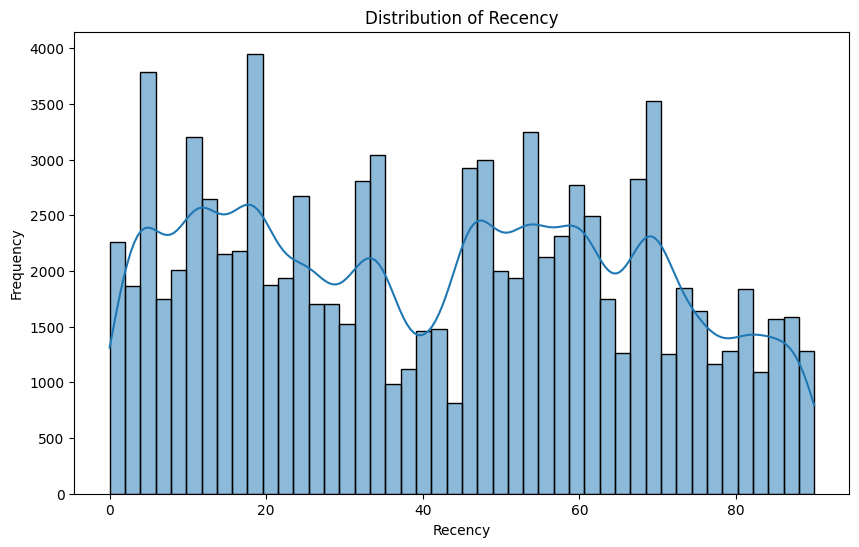

In [62]:
%matplotlib inline
def plot_recency_distribution(data, column='Recency'):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], kde=True)
    plt.title('Distribution of Recency')
    plt.xlabel('Recency')
    plt.ylabel('Frequency')
    plt.show()

plot_recency_distribution(data)

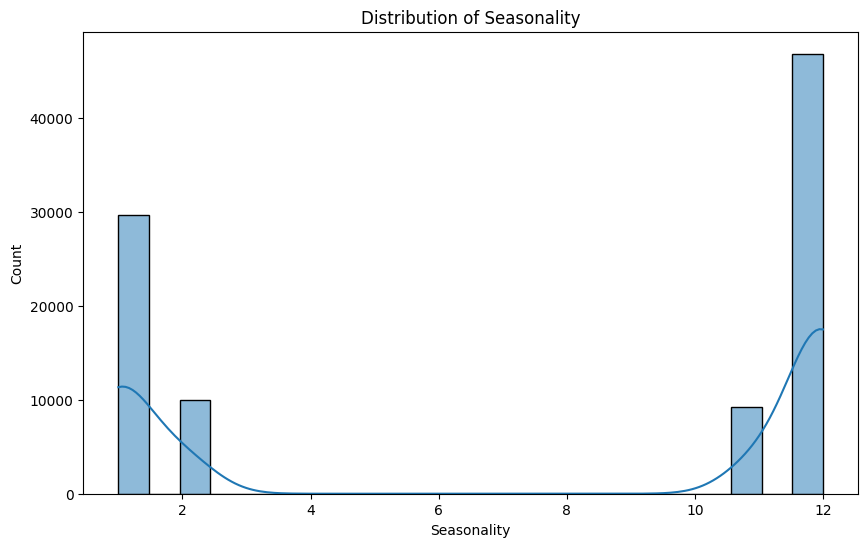

In [64]:
def plot_Seasonality_distribution(data, column='Seasonality'):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], kde=True)
    plt.title('Distribution of Seasonality')
    plt.xlabel('Seasonality')
    plt.ylabel('Count')
    plt.show()


plot_Seasonality_distribution(data)

In [ ]:
def plot_seasonality_distribution(data, column='Seasonality'):
    plt.figure(figsize=(10, 6))
    sns.countplot(data[column])
    plt.title('Distribution of Seasonality (Month)')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.show()
 

plot_seasonality_distribution(data)